In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ray
import ray.rllib

import pyquake.proto
import q1physrl.env

/home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
ray.init()

2020-02-14 09:05:09,165	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-02-14 09:05:09,168	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-14 09:05:09,261	INFO resource_spec.py:212 -- Starting Ray with 1.56 GiB memory available for workers and up to 0.8 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-14 09:05:09,543	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.
2020-02-14 09:05:09,625	WARNING services.py:1004 -- Failed to start the reporter. The reporter requires 'pip install psutil'.


{'node_ip_address': '192.168.178.24',
 'redis_address': '192.168.178.24:56090',
 'object_store_address': '/tmp/ray/session_2020-02-14_09-05-09_167595_27035/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-14_09-05-09_167595_27035/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-02-14_09-05-09_167595_27035'}

In [3]:
trainer = ray.rllib.agents.ppo.PPOTrainer(
    env=q1physrl.env.PhysEnv,
    config={"env_config": {"num_envs": 100}, "gamma": 0.9}
)

2020-02-14 09:05:09,969	INFO trainer.py:377 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-02-14 09:05:09,987	ERROR logger.py:328 -- pip install 'ray[tune]' to see TensorBoard files.
2020-02-14 09:05:09,989	WARNING logger.py:417 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2020-02-14 09:05:09,994	INFO trainer.py:524 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=27086) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=27086)   warnings.warn(msg)
(pid=27086) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=27086)   warnings.warn(msg)
(pid=27087) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=27087)   warnings.warn(msg)
(pid=27087) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma modu

2020-02-14 09:05:19,637	WARNING util.py:41 -- Install gputil for GPU system monitoring.
2020-02-14 09:05:19,638	WARNING util.py:44 -- Install psutil to monitor system performance.


In [4]:
# FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-26_18-30-58enaj6dzm/checkpoint_54/checkpoint-54'
# FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-27_21-54-210mybah6w/checkpoint_38/checkpoint-38'
# FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-29_18-38-4507_f9y9o/checkpoint_42/checkpoint-42'
# FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-29_18-48-34d96of62s/checkpoint_147/checkpoint-147'
# FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-29_19-42-287sgxfik5/checkpoint_20/checkpoint-20'
# FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-29_20-03-30jpgozu93/checkpoint_209/checkpoint-209'
# FNAME = '/home/matt/checkpoint-141'
# FNAME = '/home/matt/checkpoint-8421'
# FNAME = '/home/matt/checkpoint-701'
# FNAME = '/home/matt/checkpoint-13421'
# FNAME = '/home/matt/checkpoint-5441'
# FNAME = '../checkpoints/checkpoint-4169'
# FNAME = '../checkpoints/checkpoint-4468'
# FNAME = '../checkpoints/checkpoint-8054'
# FNAME = '../checkpoints/checkpoint-7867'
# FNAME = '../checkpoints/checkpoint-5199'
# FNAME = '../checkpoints/checkpoint-8765'
# FNAME = '../checkpoints/checkpoint-11625'
# FNAME = '../checkpoints/checkpoint-2458'
# FNAME = '../checkpoints/checkpoint-485'
# FNAME = '../checkpoints/checkpoint-82'
FNAME = '../checkpoints/checkpoint-2929'


trainer.restore(FNAME)

2020-02-14 09:05:19,811	WARNING trainable.py:210 -- Getting current IP.
2020-02-14 09:05:19,813	INFO trainable.py:416 -- Restored on 192.168.178.24 from checkpoint: ../checkpoints/checkpoint-2929
2020-02-14 09:05:19,816	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 2929, '_timesteps_total': 58580000, '_time_total': 33587.7549469471, '_episodes_total': 272719}


In [5]:
DEMO_FILE_NAME = "wr29.dem"

In [6]:
obs, action = await q1physrl.env.eval_coro(26000, trainer, DEMO_FILE_NAME)
obs = np.array(obs) * q1physrl.env._OBS_SCALE

Plot raw actions over time

In [7]:
# plt.plot(obs[:, 1])
# plt.plot(obs[:, 2])

# plt.show()
# for a, k in zip(action.T, q1physrl.env.Key):
#     plt.title(str(k))
#     plt.plot(obs[:, 2] / 30 - 1)
#     plt.plot(np.arange(len(a)), a, marker='+')
#     plt.show()

Convert the actions into movements, and plot them over time

In [8]:
action_to_move = q1physrl.env.ActionToMove(1)
action_to_move.vector_reset()
yaw, smove, fmove, jump = np.array([action_to_move.map([a], np.float32(0.014 * i)[None])
                                for i, a in enumerate(action)])[:, :, 0].T

ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<AsyncClient._read_messages() running at /home/matt/pyquake/pyquake/client.py:215> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f43b1015a68>()]> cb=[AsyncClient.connect.<locals>.<lambda>() at /home/matt/pyquake/pyquake/client.py:303]>


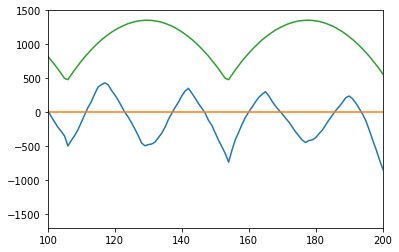

In [9]:
plt.xlim(100, 200)
plt.plot(20 * (yaw - 90))
plt.plot(smove, label='smove')
plt.plot(jump * 100, label='jump')
plt.plot(20 * obs[:, q1physrl.env.Obs.Z_POS])
plt.legend()

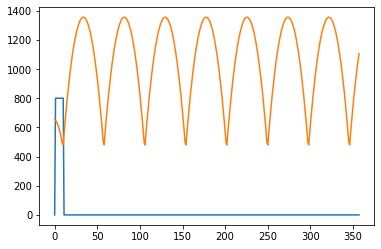

In [10]:
plt.plot(fmove)
plt.plot(20 * obs[:, q1physrl.env.Obs.Z_POS])

Take the actions from the above run and push them through the PhysEnv.
Comparing the observations will reveal potential bugs.

In [11]:
env = q1physrl.env.PhysEnv({'num_envs': 1})
o, = env.vector_reset()

obs2= [o]

for a in action:
    (o,), _, _, _ = env.vector_step([a])
    obs2.append(o)
    
obs2 = np.stack(obs2[:-1])
obs2 *= q1physrl.env._OBS_SCALE

/home/matt/100m-rl/q1physrl/phys.py:99: RuntimeWarning: invalid value encountered in true_divide
  wish_vel / unclipped_wish_speed[:, None],
/home/matt/100m-rl/q1physrl/phys.py:104: RuntimeWarning: invalid value encountered in true_divide
  (wish_speed / unclipped_wish_speed),


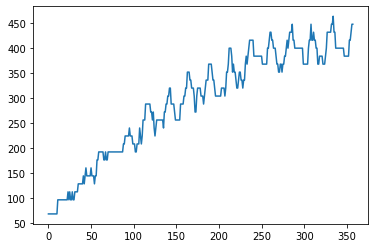

In [12]:
plt.plot(np.max(np.abs(obs - obs2), axis=1))
# plt.plot(np.argmax(np.abs(obs - obs2), axis=1))

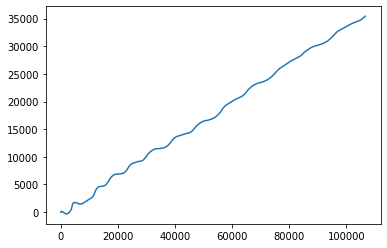

In [13]:
plt.plot(np.cumsum(obs2[:, 3]), np.cumsum(obs2[:, 4]))

Open the demo file we just made, and measure the speed

In [14]:
view_entity = None
origin = None
origins = []
times = []

time = None

def patch_vec(old_vec, update):
    return tuple(v if u is None else u for v, u in zip(old_vec, update))

with open(DEMO_FILE_NAME, 'rb') as f:
    for angles, msg in pyquake.proto.read_demo_file(f):
        if msg.msg_type == pyquake.proto.ServerMessageType.SETVIEW:
            view_entity = msg.viewentity
        if (msg.msg_type == pyquake.proto.ServerMessageType.SPAWNBASELINE and
                msg.entity_num == view_entity):
            origin = msg.origin
        if (msg.msg_type == pyquake.proto.ServerMessageType.UPDATE and
                msg.entity_num == view_entity):
            origin = patch_vec(origin, msg.origin)
            origins.append(origin)
            times.append(time)
        if msg.msg_type == pyquake.proto.ServerMessageType.TIME:
            time = msg.time

distance travelled 1618.5
final speed 457.43145743145743


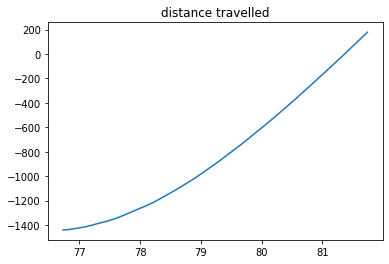

In [15]:
print('distance travelled', np.diff(np.array([o[1] for o in origins])).sum())
print('final speed', np.diff([o[1] for o in origins][-100:]).mean() / 0.014)
plt.title('distance travelled')
plt.plot(times, [o[1] for o in origins])

Just run forwards and see how much reward we get

In [16]:
env = q1physrl.env.PhysEnv({'num_envs': 1})
o, = env.vector_reset()
os = []
done = False
reward = 0
while not done:
    a = np.array([0, 0, 1, 0, 0])
    (o,), (r,), (done,), _ = env.vector_step(a[None])
    reward += r
    os.append(o)
os = np.stack(os)
os *= q1physrl.env._OBS_SCALE

/home/matt/100m-rl/q1physrl/phys.py:89: RuntimeWarning: invalid value encountered in true_divide
  return np.where((speed > 0)[:, None], h_vel * (new_speed / speed)[:, None], h_vel)


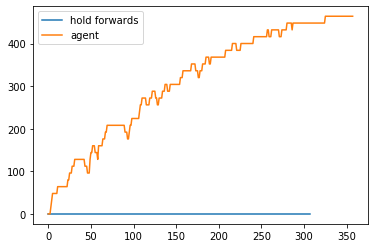

In [17]:
plt.plot(os[:, 4], label='hold forwards')
plt.plot(obs[:, 4], label='agent')
plt.legend()

In [18]:
os[:, 4].sum() * 0.014

1546.496

In [19]:
obs[:, 4].sum() * 0.014

1570.688

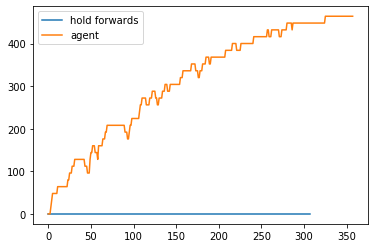

In [20]:
plt.plot(os[:, 4], label='hold forwards')
plt.plot(obs[:, 4], label='agent')
plt.legend()